# Stable Diffusion Batch Prediction with Ray AIR

In this example, we will showcase how to use the Ray AIR for **Stable Diffusion batch inference**. Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from CompVis, Stability AI and LAION. It is trained on 512x512 images from a subset of the LAION-5B database. LAION-5B is the largest, freely accessible multi-modal dataset that currently exists. For more information on Stable Diffusion, click [here](https://huggingface.co/blog/stable_diffusion).

We will use Ray Data and a pretrained model from Hugging Face hub. Note that you can easily adapt this example to use other similar models.

It is highly recommended to read [Ray AIR Key Concepts](air-key-concepts) and [Ray Data Key Concepts](data_key_concepts) before starting this example.

```{note}
In order to run this example, make sure your Ray cluster has access to at least one GPU with 16 or more GBs of memory. The amount of memory needed will depend on the model.
```

In [1]:
model_id = "stabilityai/stable-diffusion-2-1"
prompt = "a photo of an astronaut riding a horse on mars"

In [2]:
import ray

We define a {ref}`runtime environment <runtime-environments>` to ensure that the Ray workers have access to all the necessary packages. You can omit the `runtime_env` argument if you have all of the packages already installed on each node in your cluster.

In [ ]:
ray.init(
    runtime_env={
        "pip": [
            "accelerate>=0.16.0",
            "transformers>=4.26.0",
            "diffusers>=0.13.1",
            "xformers>=0.0.16",
            "torch",
        ]
    }
)

For the purposes of this example, we will use a very small toy dataset composed of multiple copies of our prompt. Ray Data can handle much bigger datasets with ease.

In [4]:
import ray.data
import pandas as pd

ds = ray.data.from_pandas(pd.DataFrame([prompt] * 4, columns=["prompt"]))

Since we will be using a pretrained model from Hugging Face hub, the simplest way is to use {meth}`map_batches <ray.data.Datastream.map_batches>` with a [callable class UDF](transform_datastreams_callable_classes). This will allow us to save time by initializing a model just once and then feed it multiple batches of data.

In [5]:
class PredictCallable:
    def __init__(self, model_id: str, revision: str = None):
        from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

        # Use xformers for better memory usage
        from xformers.ops import MemoryEfficientAttentionFlashAttentionOp
        import torch

        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_id, torch_dtype=torch.float16
        )
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(
            self.pipe.scheduler.config
        )
        self.pipe.enable_xformers_memory_efficient_attention(
            attention_op=MemoryEfficientAttentionFlashAttentionOp
        )
        # Workaround for not accepting attention shape using VAE for Flash Attention
        self.pipe.vae.enable_xformers_memory_efficient_attention(attention_op=None)
        self.pipe = self.pipe.to("cuda")

    def __call__(self, batch: pd.DataFrame) -> pd.DataFrame:
        import torch

        # Set a different seed for every image in batch
        self.pipe.generator = [
            torch.Generator(device="cuda").manual_seed(i) for i in range(len(batch))
        ]
        return self.pipe(list(batch["prompt"])).images

All that is left is to run the `map_batches` method on the dataset. We specify that we want to use one GPU for each Ray Actor that will be running our callable class.

```{tip}
If you have access to large GPUs, you may want to increase the batch size to better saturate them.
```

In [6]:
preds = ds.map_batches(
    PredictCallable,
    batch_size=1,
    fn_constructor_kwargs=dict(model_id=model_id),
    compute="actors",
    batch_format="pandas",
    num_gpus=1,
)
images = preds.take_all()

2023-02-28 10:38:32,723	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(PredictCallable)]
MapBatches(PredictCallable), 0 actors [0 locality hits, 1 misses]: 100%|██████████| 1/1 [01:46<00:00, 106.33s/it]


After `map_batches` is done, we can view our images.

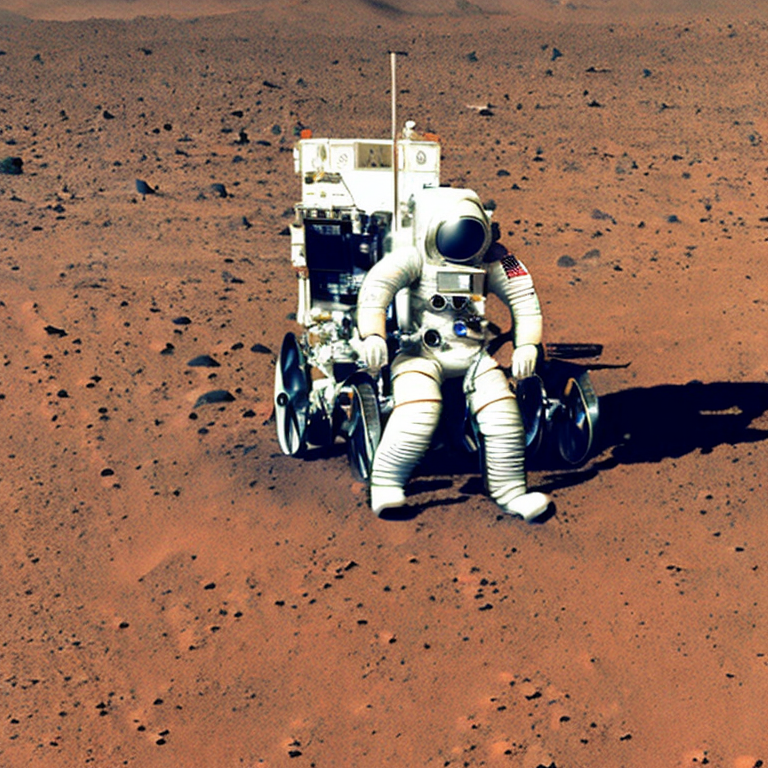

In [7]:
images[0]

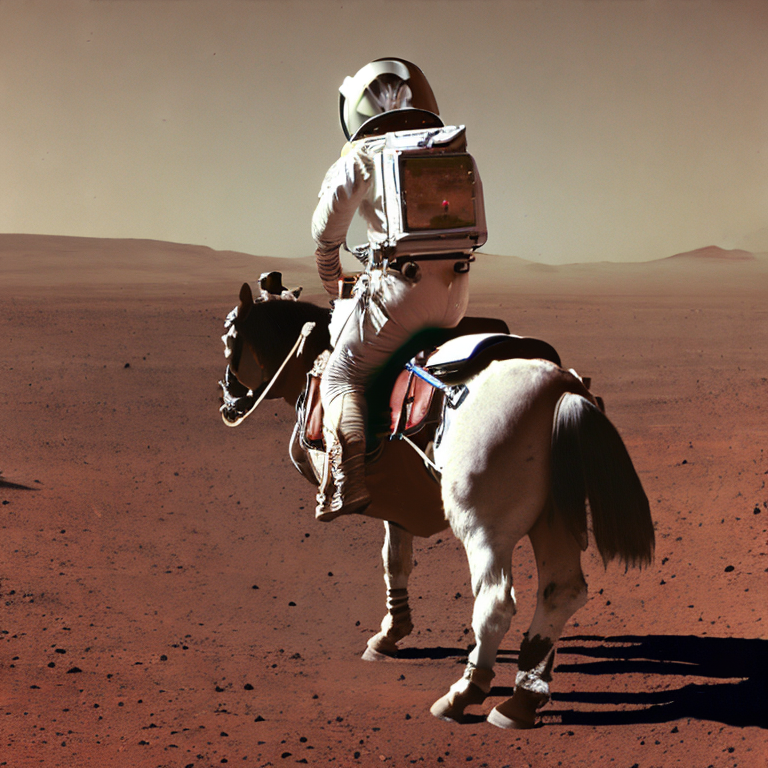

In [8]:
images[1]

You may notice that we are not using an AIR {class}`Predictor <ray.train.predictor.Predictor>` here. This is because AIR does not implement an out of the box Predictor for Diffusers. We could implement it ourselves, but Predictors are mainly intended to be used with AIR {class}`Checkpoints <ray.air.checkpoint.Checkpoint>`, and those are not necessary for this example. See {ref}`air-predictors` for more information and usage examples.